<a href="https://colab.research.google.com/github/HeningWang/numpyro_adjective_modelling/blob/main/01_gb_normal_logit_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules and dependencies


In [2]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!git clone https://github.com/HeningWang/numpyro_adjective_modelling.git
!pip install siuba

import os

from IPython.display import set_matplotlib_formats
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("gpu")

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.12.1")

  Preparing metadata (setup.py) ... done
Cloning into 'numpyro_adjective_modelling'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 142 (delta 61), reused 51 (delta 22), pack-reused 0
Receiving objects: 100% (142/142), 14.84 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (61/61), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.1 MB/s eta 0:00:00


In [3]:
print(jax.__version__)
jax.devices()

0.4.13


[gpu(id=0)]

In [4]:
import sys
sys.path.append('/content/numpyro_adjective_modelling')

Some helper functions:

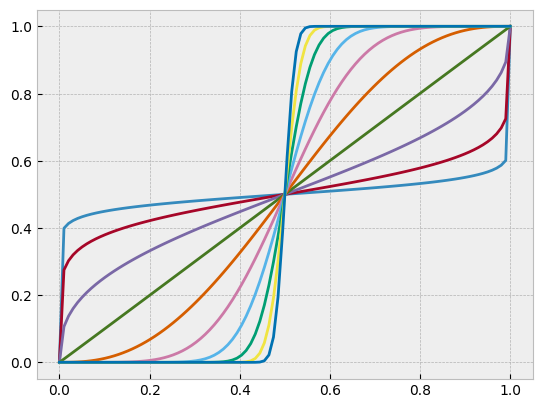

In [5]:
import numpy as np
from scipy.stats import norm

%matplotlib inline
from scipy.special import betainc
import numpy as np
import math
import matplotlib.pyplot as plt

x = np.linspace(0., 1., 100)
N = 10

for i in range(N):
    k = 0.5 * np.exp(i) / N
    plt.plot(x, betainc(k, k, x))

#plt.gca().set_xlim(0,1)
#plt.gca().set_ylim(0,1)
#plt.show()

def link_betacdf(x, param=None):
  N = 10
  k = 0.5 * jnp.exp(param) / N
  return jax.scipy.stats.beta.cdf(x,k,k)


In [6]:
# Mutate the dataset to include the states of the objects
# ... states are independent variables for models

def extract_states(line):
    states = []
    for i in range(6):
      color = 1 if line[10 + i] == "blue" else 0
      form = 1 if line[16 + i] == "circle" else 0
      new_obj = (line[4 + i], color, form)
      states.append(new_obj)
    return jnp.array(states)


# Transform/rescale slider value from range 0 to 100 to 0 to 1
# ... in order to match predicted probability from models

def transformation_data(slider_value, link = None):
    if link == "identity":
      slider_value = jnp.clip(slider_value, 0, 100)
      transformed_prob = slider_value / 100
    elif link == "logit":
        transformed_prob = 1 / (1 + math.exp(-slider_value))
    return transformed_prob


def compute_alpha_beta_concentration(mu, v):
    alpha = mu * v
    beta = (1 - mu) * v
    return alpha, beta

def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

def plot_dist(d, ax=None):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))

    if ax is None:
        ax = plt.subplot(111)

    width = 0.3
    bins = [x-width/2 for x in range(1, len(data) + 1)]
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(range(1, len(data) + 1)))
    ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")

def get_results(posterior):
    results = {}
    support = posterior.enumerate_support()
    data = [posterior.log_prob(s).exp().item() for s in posterior.enumerate_support()]
    results["support"] = support
    results["probs"] = data
    return results

def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

In [7]:
# Import dataset
dataset_url = "/content/numpyro_adjective_modelling/dataset/dataset_slider.csv"
df = pd.read_csv(dataset_url)

# subset data to only include combination dimension_color
df = df[df['combination'] == 'dimension_color']
df.reset_index(inplace=True, drop=True)

# Mutate the dataset to include the states of the objects
df_experiment = df.copy()
df_experiment["states"] = df_experiment.apply(lambda row: extract_states(row), axis=1)

df_experiment.prefer_first_1st = jnp.clip(df_experiment.prefer_first_1st.to_numpy(), 0, 100)
df_experiment.prefer_first_1st = df_experiment.prefer_first_1st/100
print(df_experiment.prefer_first_1st.describe())


count    3125.000000
mean        0.700768
std         0.381771
min         0.000000
25%         0.500000
50%         0.910000
75%         1.000000
max         1.000000
Name: prefer_first_1st, dtype: float64


In [8]:
from sklearn.model_selection import train_test_split
# split the dataset into training and test sets
#train, test = train_test_split(df_experiment, test_size=0.99, random_state=42)

# use the whole dataset as training set
train = df_experiment

print(train.shape)

states_train = jnp.stack([cell for cell in train.states])
empirical_train = jnp.array(train.prefer_first_1st.to_numpy())

(3125, 28)


In [9]:
def get_threshold_kp(states, k=0.5):
    min_val = jnp.min(states[:,0])
    max_val = jnp.max(states[:,0])
    threshold = max_val - k * (max_val - min_val)
    return threshold

def get_threshold_kp_weighted(states, states_prior, k=0.5):
    sorted_indices = jnp.unique(jnp.argsort(states[:, 0] * states_prior), size = 6)
    sorted_states = states[sorted_indices]
    min_val = sorted_states[0, 0]
    max_val = sorted_states[-1, 0]

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold

def get_threshold_kp_sample(states, states_prior, k=0.5):
    sample_indices = jnp.unique(dist.Categorical(probs=states_prior).sample(random.PRNGKey(0),(1,10)), size = 6)
    sorted_states = states[sample_indices][:,0]
    min_val = jnp.min(sorted_states)
    max_val = jnp.max(sorted_states)

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold


def adjMeaning(word, obj, current_state_prior, color_semvalue=0.98, form_semvalue=0.98, wf=0.6, k=0.5):
    colors = [1]  # Specify the color values
    sizes = [0]  # Specify the size values

    if word == 1:
        return numpyro.sample("color", numpyro.distributions.Bernoulli(color_semvalue)) if word == obj[1] else numpyro.sample("color", numpyro.distributions.Bernoulli(1 - color_semvalue))
    elif word == 0:
        threshold = get_threshold_kp(current_state_prior, k)
        size = obj[0]
        prob_big = 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(jnp.array([0.0]))
        return numpyro.sample("size", numpyro.distributions.Bernoulli(prob_big))


In [10]:
# Example usage for meaning function
#states = jnp.array([[10., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 0.],
#                   [3., 1., 0.],
#                   [1., 0., 1.]], dtype=jnp.float32)

#word = 0 # Example word, 0 for size
#obj = states[5]  # Example object from states

# Example prior values
#color_semvalue = 0.98
#form_semvalue = 0.98
#wf = 0.6
#k = 0.5

#print(get_threshold_kp(states))
# Call the meaning function
#with handlers.seed(rng_seed=27):
# meaning = adjMeaning(word, obj, states, color_semvalue, form_semvalue, wf, k)

#print(meaning)
#print(obj)

In [11]:
# The length of states is 6

def get_size_semval(size,threshold,wf):
  return 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(0.0)

def literal_listener_one_word(states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  threshold = get_threshold_kp(states, k)
  probs_big = jnp.array([1 - dist.Normal(obj[0] - threshold, wf * jnp.sqrt(obj[0] ** 2 + threshold ** 2)).cdf(0.0) for obj in states])
  probs = normalize(jnp.array([probs_big,probs_blue]))
  return probs

def literal_listener_recursive(word_length, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5, weighted = False):
  if word_length <= 1:
    current_states_prior = jnp.ones((2,6))
  else:
    current_states_prior = literal_listener_recursive(word_length - 1, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5)
    current_states_prior = jnp.flip(current_states_prior, axis = 0)
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  if weighted:
    threshold = get_threshold_kp_sample(states, current_states_prior[0,:], k)
  else:
    threshold = get_threshold_kp(states, k)
  probs_big = jax.vmap(get_size_semval, in_axes = (0, None, None))(states[:,0], threshold, wf)
  probs = normalize(jnp.multiply(jnp.array([probs_big,probs_blue]), current_states_prior))
  return probs


def speaker_one_word(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_one_word(states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def speaker_recursive(word_length, states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  if word_length <= 1:
    current_utt_prior = jnp.array([0, 1]) * bias
  else:
    current_utt_prior = speaker_recursive(word_length - 1, states, alpha, bias, color_semvalue, form_semvalue, wf, k)
    current_utt_prior = jnp.flip(current_utt_prior, axis = 1)
  listener = literal_listener_recursive(word_length, states, color_semvalue, form_semvalue, wf, k)
  #print(listener)
  util_speaker = jnp.log(jnp.transpose(listener)) - current_utt_prior
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def global_speaker(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_recursive(2,states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result


In [12]:
# 118 brdc sharp, target not the biggest
# 12 brdc blurred

# 119 erdc sharp
# 15 erdc blurred

index = 15
states_manuell = jnp.array([[10., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 0.],
                   [3., 1., 0.],
                   [1., 0., 1.]], dtype=jnp.float32)

#states_example = states_manuell
states_example = df_experiment.iloc[index, df_experiment.columns.get_loc("states")]
condition = df_experiment.iloc[index, df_experiment.columns.get_loc("conditions")]
distribution = df_experiment.iloc[index, df_experiment.columns.get_loc("sharpness")]
preference = df_experiment.iloc[index, df_experiment.columns.get_loc("prefer_first_1st")]
print(states_example)
print(condition + " " + distribution)
print(preference)
#print(f"literal listener one word: {literal_listener_one_word(states_example)}")
#print(f"literal listener two words: {literal_listener_recursive(2,states_example)}")
#print(f"model_prediction: {model_speaker[0][0]}")
#print(f"speaker one word: {speaker_one_word(states_example)}")
print(f"speaker two words global: {global_speaker(states_example)}")
print("________________________________________")
print(f"speaker two words incremental: {speaker_recursive(2,states_example)}")
print("________________________________________")
print(f"speaker two words incremental: {speaker_recursive(2,states_example, k = 0.1)}")

[[ 5.  0.  0.]
 [10.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]
 [ 5.  0.  1.]
 [ 5.  0.  1.]]
erdc blurred
0.01
speaker two words global: [[0.50000006 0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.50000006 0.5       ]
 [0.50000006 0.5       ]]
________________________________________
speaker two words incremental: [[0.5219833  0.47801667]
 [0.57983774 0.4201623 ]
 [0.35003054 0.64996946]
 [0.35003054 0.64996946]
 [0.5219833  0.47801667]
 [0.5219833  0.47801667]]
________________________________________
speaker two words incremental: [[0.47634175 0.52365834]
 [0.62912846 0.37087154]
 [0.41566595 0.5843341 ]
 [0.41566595 0.5843341 ]
 [0.47634175 0.52365834]
 [0.47634175 0.52365834]]


In [13]:
# index = 120, condition = zrdc sharp, there is a difference in threshold of 0.5
# index = 15, erdc blurred, very different result
print(f"kp:{get_threshold_kp(states_example,0.5)}")
print(f"kp weighted flat: {get_threshold_kp_weighted(states_example,jnp.ones((2,6)),0.5)}")
print(f"kp weighted: {get_threshold_kp_weighted(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
print(f"kp sample: {get_threshold_kp_sample(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
threshold = 6
1 - dist.Normal(10. - threshold, 0.6 * jnp.sqrt(10. ** 2 + threshold ** 2)).cdf(-0.5)

print(literal_listener_one_word(states_example)[1,:])
# this is also a not normal case, because target has size of 9 instead of 10
# also there is no difference on listener side

kp:5.5
kp weighted flat: 5.0
kp weighted: 5.0
kp sample: 5.5
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


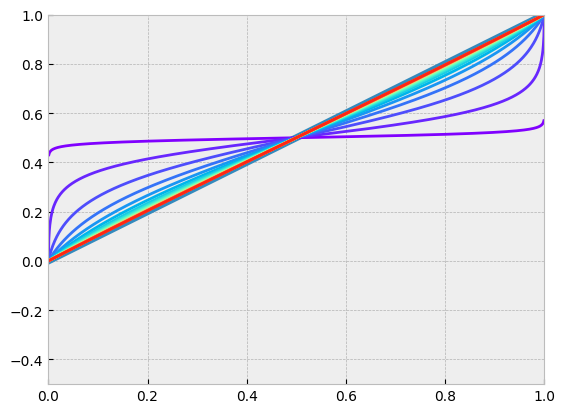

In [14]:
#def scaled_logit(p, s):
#    return s * -jnp.log((1 / p) - 1)

#def compute_x0(s):
#    return 1 / (jnp.exp(1 / (-2 * s)) + 1)

#def x_trans(x, x_0):
#    return x * (x_0 - (1 - x_0)) + (1 - x_0)

#def link_logit(p, s):
#    return scaled_logit(x_trans(p, compute_x0(s)), s) + 0.5

def link_linear(x, param):
  return param * x - (param / 2)

def link_logit(p,s):
  x0 = 1 / (jnp.exp(1 / (-2 * s)) + 1)
  xtrans = p * (x0 - (1 - x0)) + (1 - x0)
  return s * -jnp.log((1 / xtrans) - 1) + 0.5

def link_logis(x, param = 1):
    return 1 / (1 + jnp.exp(param * -(x - 0.5)))

def link_identity(x, param = 1):
    return x

# Generate a sequence of values
a = jnp.linspace(0.01, 1, 20)

# Plot the function fin(x,1)
x_values = jnp.linspace(0, 1, 1000)
y_values = link_logit(x_values, 20)
plt.plot(x_values, y_values, linewidth=5)
# Plot the function fin(x,s) for each value of s in a
for i, s in enumerate(a):
    y_values = link_logit(x_values, s)
    plt.plot(x_values, y_values, color=plt.cm.rainbow(i / len(a)))

plt.xlim([0, 1])
plt.ylim([-0.5, 1])
plt.show()

In [15]:
id = df_experiment.id.to_numpy()

In [16]:
#vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))
#model_prob = vectorized_speaker(2,states_train, 1,1,0.5,0.5,0.5,0.5)
#print(jnp.shape(model_prob))
#print(jnp.shape(model_prob[:,0,0]))
#slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0],20)

#slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
#print(jnp.shape(slider_predict))

In [17]:
# define the conditioned model for MCMC
vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))

def model_gb_normal(states = None, data = None):
  alpha = numpyro.sample("alpha", dist.HalfNormal(5))
  bias = numpyro.sample("bias", dist.HalfNormal(5))
  color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
  form_semvalue = color_semvalue
  wf = numpyro.sample("wf", dist.Uniform(0,1))
  k = numpyro.sample("k", dist.Uniform(0, 1))
  steepness = numpyro.sample("steepness", dist.HalfNormal(2))
  sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

  with numpyro.plate("data", len(states)):
    model_prob = jax.vmap(global_speaker, in_axes=(0,None,None,None,None,None,None))(states_train, alpha, bias, color_semvalue, form_semvalue, wf, k)
    slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
    slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
    if data is not None:
      data = jnp.clip(data, 1e-5, 1 - 1e-5)
    numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)

def model_inc_utt_parallel_normal(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = numpyro.sample("wf", dist.Uniform(0,1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)



def model_inc_utt_parallel_beta(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
    k = numpyro.sample("k", dist.Uniform(0, 1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(5))
    v = numpyro.sample("v", dist.Uniform(0,2))

    form_semvalue = color_semvalue
    wf = numpyro.sample("wf", dist.Uniform(0,1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_identity, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      #slider_predict = jnp.clip(model_prob[:,0,0], 1e-5, 1 - 1e-5)
      alpha, beta = compute_alpha_beta_concentration(slider_predict, v)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.Beta(alpha, beta), obs=data)


def model_inc_hierarchical_normal(id, states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = numpyro.sample("wf", dist.Uniform(0,1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

    n_ids = len(np.unique("id"))
    mu = numpyro.sample("mu", dist.Normal(0,1))
    s = numpyro.sample("s", dist.HalfNormal(0.25))
    with numpyro.plate("plate_i", n_ids):
        intercept = numpyro.sample("intercept", dist.Normal(mu, s))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = intercept[id] + slider_predict
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)


In [18]:
'''
def render_model(data):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = numpyro.sample("wf", dist.Uniform(0,1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))

    #RSA_predict = numpyro.deterministic("RSA_predict", gamma + color_semvalue + form_semvalue + k +wf +bias)

    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))
    with numpyro.plate("data",len(data)):
      listener = numpyro.deterministic("listener", k + wf + color_semvalue)
      speaker = numpyro.deterministic("speaker", listener + gamma + bias)
      slider_value = numpyro.deterministic("slider_value", speaker + steepness)
      numpyro.sample("obs", dist.TruncatedNormal(slider_value, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)

dummy_data = jnp.ones(10)
'''

'\ndef render_model(data):\n    gamma = numpyro.sample("gamma", dist.HalfNormal(5))\n    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))\n    form_semvalue = color_semvalue\n    k = numpyro.sample("k", dist.Uniform(0, 1))\n    wf = numpyro.sample("wf", dist.Uniform(0,1))\n    bias = numpyro.sample("bias", dist.HalfNormal(5))\n\n    #RSA_predict = numpyro.deterministic("RSA_predict", gamma + color_semvalue + form_semvalue + k +wf +bias)\n\n    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))\n    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))\n    with numpyro.plate("data",len(data)):\n      listener = numpyro.deterministic("listener", k + wf + color_semvalue)\n      speaker = numpyro.deterministic("speaker", listener + gamma + bias)\n      slider_value = numpyro.deterministic("slider_value", speaker + steepness)\n      numpyro.sample("obs", dist.TruncatedNormal(slider_value, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)\n\ndummy_data = jnp.o

In [19]:
#numpyro.render_model(render_model, model_args=(dummy_data,), render_params=True, filename="/content/drive/MyDrive/model_specification.png")

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# define the MCMC kernel and the number of samples
rng_key = random.PRNGKey(11)
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_gb_normal, dense_mass=True, max_tree_depth=15, target_accept_prob=0.95)
mcmc_inc = MCMC(kernel, num_warmup=5000,num_samples=30000,num_chains=1)
mcmc_inc.run(rng_key_, states_train, empirical_train)

# print the summary of the posterior distribution
mcmc_inc.print_summary()

# Get the MCMC samples and convert to a DataFrame
posterior_inc = mcmc_inc.get_samples()
df_inc = pd.DataFrame(posterior_inc)

# Save the DataFrame to a CSV file
df_inc.to_csv('/content/drive/MyDrive/posterior_samples/01_gb_normal_logit_support.csv', index=False)

sample: 100%|██████████| 35000/35000 [1:36:06<00:00,  6.07it/s, 63 steps of size 4.86e-02. acc. prob=0.94]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      7.61      2.11      7.31      4.18     10.97   3994.14      1.00
            bias      0.27      0.08      0.26      0.14      0.38   4164.78      1.00
  color_semvalue      0.97      0.00      0.97      0.97      0.98   4125.10      1.00
               k      0.48      0.01      0.48      0.46      0.50  13055.80      1.00
           sigma      0.10      0.00      0.10      0.10      0.10  23840.31      1.00
       steepness      2.13      1.12      1.93      0.47      3.77  12205.66      1.00
              wf      0.68      0.03      0.68      0.64      0.72   4115.84      1.00

Number of divergences: 108


In [23]:
#df_inc.to_csv('/content/drive/MyDrive/hierarchical_inc_logit_sample_normal_1k.csv', index=False)

In [24]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_inc_utt_parallel_normal, posterior_inc)
predictions = predictive(rng_key_, states = states_train)["obs"]
print(jnp.shape(predictions))

(30000, 3125)


In [25]:
df_pred = df_experiment.filter(["id","sharpness","relevant_property","states", "prefer_first_1st"])
df_pred["mean_predictions"] = (jnp.mean(predictions, axis=0) - 0.5)
df_pred["prefer_first_1st"] = df_pred["prefer_first_1st"] - 0.5
df_pred["std_predictions"] = jnp.std(predictions, axis=0)
print(df_pred.head())

print(df_pred.prefer_first_1st.describe())
print(df_pred.mean_predictions.describe())

   id sharpness relevant_property  \
0   1   blurred            second   
1   1   blurred             first   
2   1   blurred            second   
3   1   blurred              both   
4   1   blurred              both   

                                              states  prefer_first_1st  \
0  [[8.0, 0.0, 0.0], [9.0, 1.0, 1.0], [9.0, 0.0, ...              0.47   
1  [[5.0, 0.0, 0.0], [10.0, 0.0, 1.0], [5.0, 0.0,...              0.48   
2  [[8.0, 0.0, 0.0], [10.0, 1.0, 1.0], [10.0, 0.0...              0.48   
3  [[2.0, 0.0, 0.0], [10.0, 1.0, 1.0], [9.0, 0.0,...              0.48   
4  [[2.0, 0.0, 0.0], [10.0, 1.0, 1.0], [9.0, 0.0,...              0.48   

   mean_predictions  std_predictions  
0          0.315137         0.157299  
1          0.285762         0.175132  
2          0.315677         0.157694  
3          0.329587         0.150553  
4          0.327965         0.151819  
count    3125.000000
mean        0.200768
std         0.381771
min        -0.500000
25%         0.

In [26]:
from plotnine import *
from siuba import *

In [27]:
aggregated_df_pred = df_pred  >> group_by("sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std())
print(aggregated_df_pred)

  sharpness relevant_property  mean_empirical  std_empirical  mean_pred  \
0   blurred              both        0.252476       0.329657   0.329532   
1   blurred             first        0.298959       0.299281   0.264986   
2   blurred            second        0.057861       0.424966   0.315524   
3     sharp              both        0.208442       0.379120   0.328249   
4     sharp             first        0.350962       0.269893   0.292692   
5     sharp            second        0.047803       0.443573   0.315403   

   std_pred  
0  0.000906  
1  0.032778  
2  0.000573  
3  0.000881  
4  0.004988  
5  0.000594  


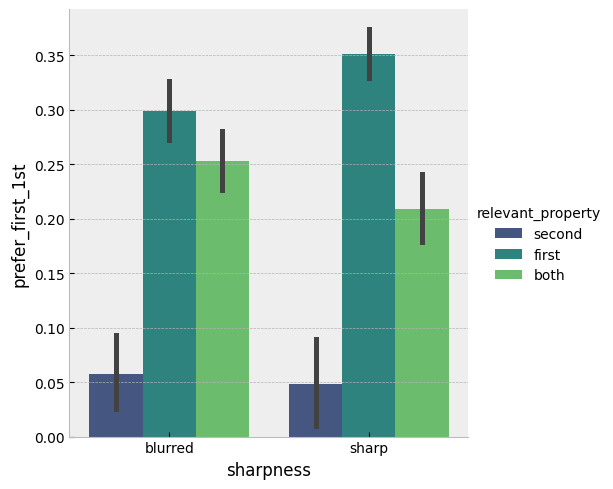

In [28]:
sns.catplot(x='sharpness', y='prefer_first_1st', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis')

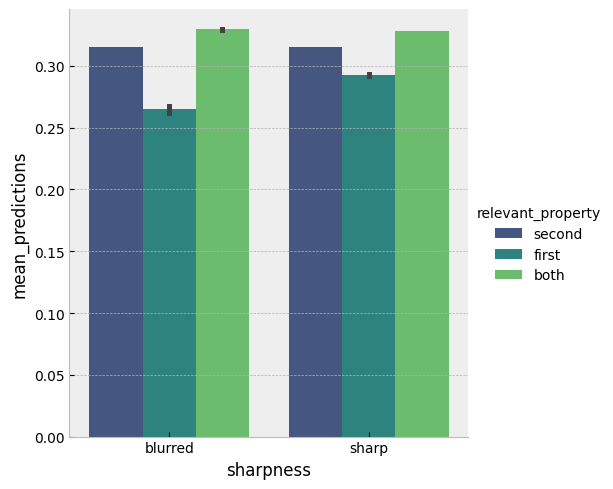

In [29]:
sns.catplot(x='sharpness', y='mean_predictions', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis')

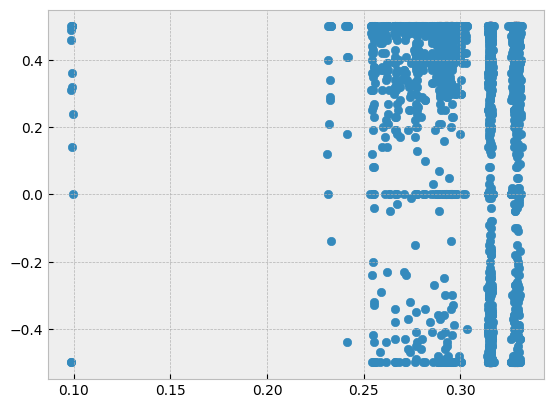

In [30]:
plt.scatter(df_pred.mean_predictions,df_pred.prefer_first_1st)
plt.show()

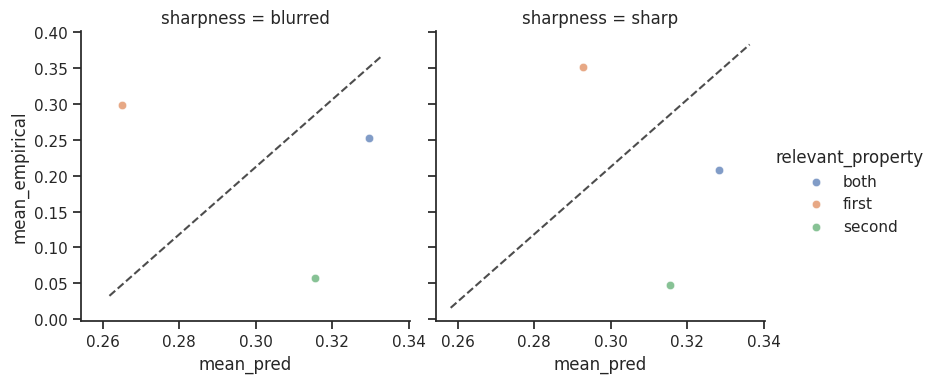

In [31]:
sns.set(style="ticks")

g = sns.FacetGrid(aggregated_df_pred, col="sharpness", hue="relevant_property", height=4)
g.map(sns.scatterplot,"mean_pred", "mean_empirical", alpha=0.7)

# Add a 45 degree line to each facet
for ax in g.axes.flatten():
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

g.add_legend()

plt.show()


In [32]:
from sklearn.metrics import r2_score, mean_squared_error

print(f"R2 score between true and predicted data is: {r2_score(df_pred.prefer_first_1st,df_pred.mean_predictions)}")
print(f"R2 score between aggregated true and predicted data is: {r2_score(aggregated_df_pred.mean_pred,aggregated_df_pred.mean_empirical)}")
print(f"MSE between true and predicted data is: {mean_squared_error(df_pred.prefer_first_1st,df_pred.mean_predictions)}")

R2 score between true and predicted data is: -0.10007777334955037
R2 score between aggregated true and predicted data is: -52.05697102569874
MSE between true and predicted data is: 0.16028431057929993


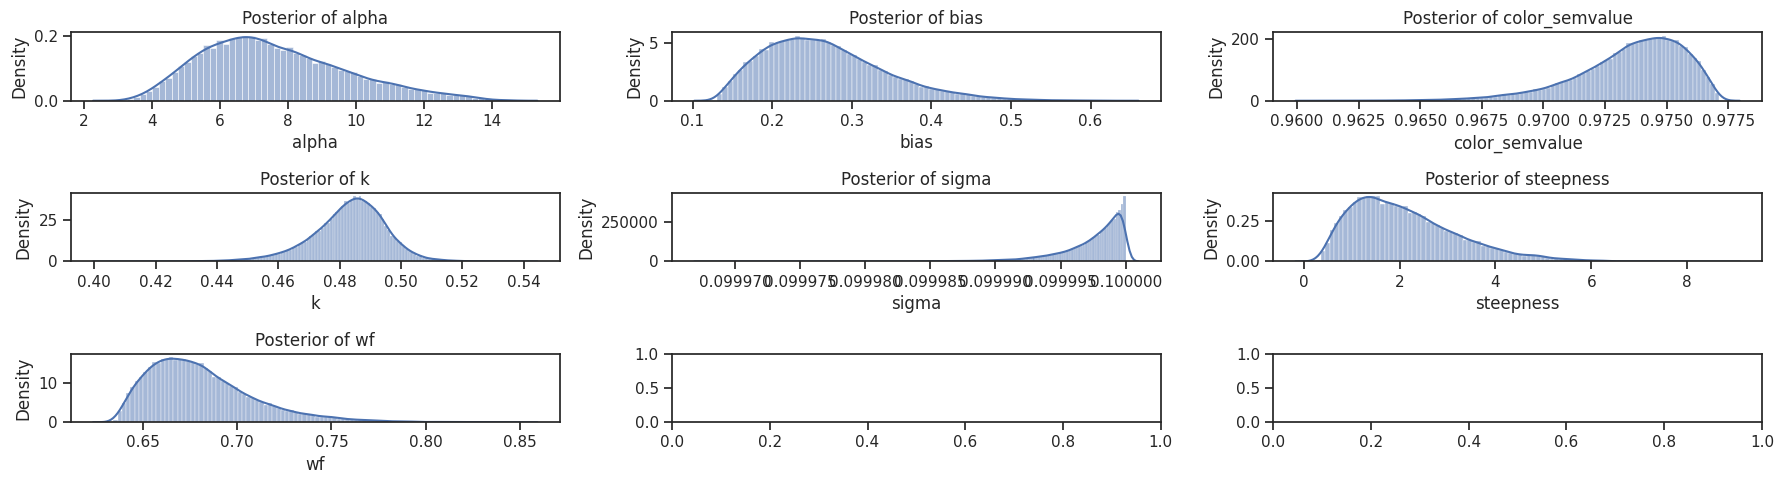

In [33]:
def plot_parameter(df, type = "Posterior"):
    # create subplots based on how many parameters (ncols) we have
    numbers = len(df.columns)
    ncols = 3
    nrows = int(np.ceil(numbers/ncols))
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(18, 5))
    # plot each parameter
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, kde_kws = dict(cut = 3), stat="density", ax=axes[i//ncols, i%ncols])
        axes[i//ncols, i%ncols].set_title(f"{type} of {col}")
    plt.tight_layout()
    plt.show()

plot_parameter(df_inc)

In [34]:
df_grouped = df_pred.groupby(['id', 'sharpness', 'relevant_property'])['mean_predictions'].mean().reset_index()


#aggregated_df_pred_pps = df_pred  >> group_by("id","sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std())
#print(aggregated_df_pred_pps)


In [35]:
#sns.catplot(x='sharpness', y='prefer_first_1st', hue='relevant_property',
#            data=df_pred, kind='bar', palette='viridis', col='id', col_wrap=5)
#plt.show()


In [36]:
#sns.catplot(x='sharpness', y='mean_predictions', hue='relevant_property',
#            data=df_grouped, kind='bar', palette='viridis', col='id', col_wrap=5)
#plt.show()


In [37]:
import statsmodels.formula.api as smf

md_1 = smf.mixedlm("mean_predictions ~ sharpness * relevant_property", df_grouped, groups=df_grouped["id"])
md_2 = smf.mixedlm("mean_predictions ~ sharpness + relevant_property", df_grouped, groups=df_grouped["id"])
mdf_1 = md_1.fit()
mdf_2 = md_2.fit()

print(mdf_1.summary())
print(mdf_2.summary())

log_likelihood_model1 = mdf_1.llf
log_likelihood_model2 = mdf_2.llf

import scipy.stats as stats

# Assume log_likelihood_model1 and log_likelihood_model2 are the log-likelihoods for your two models
# and df_model1 and df_model2 are the degrees of freedom (number of parameters) for the two models

test_statistic = 2 * (log_likelihood_model1 - log_likelihood_model2)
df = 2

p_value = stats.chi2.sf(test_statistic, df) # sf is the survival function, which is 1 - cdf

print("Test statistic: ", test_statistic)
print("Degrees of freedom: ", df)
print("p-value: ", p_value)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg


                           Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          mean_predictions
No. Observations:            357              Method:                      REML            
No. Groups:                  119              Scale:                       0.0000          
Min. group size:             3                Log-Likelihood:              1509.5222       
Max. group size:             3                Converged:                   Yes             
Mean group size:             3.0                                                           
-------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                       0.330    0.000  812.207 0.000  0.329  0.330
sharpness[T.sha

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 44.658472
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


In [38]:
#from numpyro.infer.util import log_density
#log_density(model_inc_utt_parallel_beta, posterior_inc, states_train, empirical_train)

In [39]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])


def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(
        lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs)
    )
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            posterior_inc,
            model_inc_utt_parallel_beta,
            states_train,
            empirical_train,
        )
    )
)

AssertionError: ignored